In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

tf.__version__

'2.12.0'

In [2]:
(X_train,y_train),(_,_)=tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
X_train.shape

(60000, 28, 28)

In [53]:
y_train.shape

(60000,)

In [4]:
i=np.random.randint(0,60000)
#print(i)
print(y_train[i])
plt.imshow(X_train[i],cmap='gray')

NameError: ignored

In [5]:
X_train=X_train.reshape(X_train.shape[0],28,28,1).astype('float32')

In [6]:
X_train.shape

(60000, 28, 28, 1)

In [7]:
X_train=(X_train -127.5)/127.5

In [8]:
X_train[0].min(),X_train[0].max()

(-1.0, 1.0)

In [9]:
buffer_size=60000
batch_size=256

In [10]:
buffer_size/batch_size

234.375

In [11]:
type(X_train)

numpy.ndarray

In [12]:
X_train=tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [13]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [14]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [15]:
# 100 -> 12544
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=True, activation='tanh'))

  network.summary()

  return network

In [16]:
generator=build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [17]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [18]:
noise=tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.5031388 , -0.5490489 , -0.27342436,  0.6843331 ,  2.1778598 ,
        -2.565815  , -0.87197596, -0.64782923, -1.0783796 ,  2.0585148 ,
        -0.91298217,  0.56507283,  0.8724343 ,  0.71059257, -1.5938283 ,
         1.0707668 , -1.5169536 ,  0.4264482 , -0.38879085,  1.0217863 ,
         0.7663733 , -0.0651577 ,  1.1816813 ,  0.72141063, -0.26015764,
         0.89524883, -0.13233273, -0.3410823 , -0.16149116, -0.66184956,
        -0.23341876, -1.0307004 ,  0.29665396,  0.01361761, -0.12696381,
         1.3396137 , -1.0252231 ,  0.08614821, -1.4837356 ,  0.09811019,
        -1.1322743 ,  0.28212425, -0.825455  ,  0.30049   ,  2.4877427 ,
        -1.4210482 , -1.9872036 , -0.68447703, -0.93080425, -0.1472184 ,
        -0.02921578,  0.74975497,  0.7569065 , -0.29358613,  0.14958577,
        -1.1684943 , -1.0816016 ,  0.37515965, -1.5925705 ,  0.8748096 ,
         0.21493217, -0.9625516 , -0.19056828,  1.5793023 , -0.6370453 ,
 

In [19]:
generated_image=generator(noise,training=False)

In [20]:
generated_image.shape

TensorShape([1, 28, 28, 1])

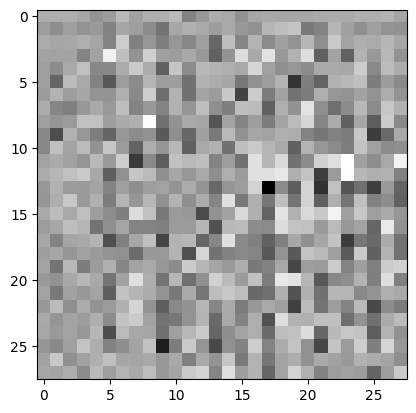

In [21]:
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [22]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [23]:
discriminator=build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [24]:
discriminator.inputs

[<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>]

In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [26]:
##Error Calculation

def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [27]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

In [29]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [30]:
epochs=100
noise_dimension=100
number_of_images=16

In [31]:
batch_size,noise_dimension

(256, 100)

In [32]:
@tf.function
def train(images):
  noise = tf.random.normal([batch_size, noise_dimension])
  #print(noise.shape)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [33]:
test_images = tf.random.normal([number_of_images, noise_dimension])
test_images.shape

TensorShape([16, 100])

In [34]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    #print(epoch)
    for image_batch in dataset:
      #print(image_batch.shape)
      train(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize = (10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i + 1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

In [35]:
train_gan(X_train,epochs,test_images)

Output hidden; open in https://colab.research.google.com to view.

In [36]:
##HOMEWORK

(X_train,y_train),(_,_)=tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


8


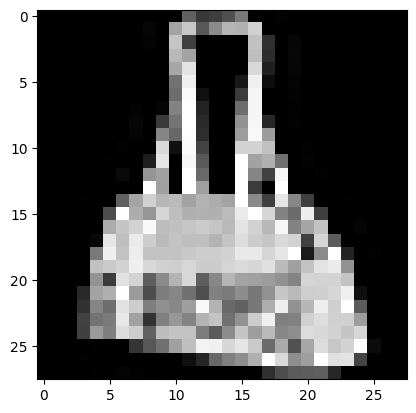

In [43]:
i=np.random.randint(0,60000)
#print(i)
print(y_train[i])
plt.imshow(X_train[i])

In [44]:
X_train=X_train.reshape(X_train.shape[0],28,28,1).astype('float32')

In [45]:
X_train=(X_train -127.5)/127.5

In [48]:
X_train[0].min(),X_train[0].max()

(-1.0, 1.0)

In [49]:
X_train=tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [50]:
train_gan(X_train,epochs,test_images)

Output hidden; open in https://colab.research.google.com to view.